<a href="https://colab.research.google.com/github/ijazahmad-star/Colab-Workspace/blob/main/oct%2027%202025/Rag(PDF)_langgraph_chromadb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install langchain langgraph pypdf faiss-cpu sentence-transformers langchain-community langchain-core langchain-google-genai langchain-openai langchain-huggingface chromadb

INFO: pip is looking at multiple versions of langchain-community to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of langchain-google-genai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of langchain-openai to determine which version is compatible with other requirements. This could take a while.
INFO: pip is looking at multiple versions of langchain-huggingface to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 5.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.4/155.4 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.9/323.9 kB 23.9 MB/s eta 0:00:

In [1]:
from dataclasses import dataclass
from langgraph.graph import MessagesState, END, StateGraph, START
from langgraph.runtime import Runtime
from langchain_openai import ChatOpenAI
from langchain_community.document_loaders import PyPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_core.messages import HumanMessage
import os

# from dotenv import load_dotenv

# load_dotenv()
# api_key = os.getenv("OPENAI_API_KEY")

In [3]:
from google.colab import userdata
api_key = userdata.get('OPENAI_API_KEY')

In [4]:
@dataclass
class ContextSchema:
    model_provider: str = "openai"
    retriever: any = None

MODELS = {
    "openai": ChatOpenAI(model="gpt-4.1-mini", api_key=api_key),
}

In [5]:
pdf_path = "/content/AdaSPEC.pdf"
loader = PyPDFLoader(pdf_path)
docs = loader.load()

splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
chunks = splitter.split_documents(docs)

embedding = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [6]:
vectorstore = Chroma.from_documents(
    documents=chunks,
    embedding=embedding,
    persist_directory="/chroma_store"
)
# vectorstore.persist()
retriever = vectorstore.as_retriever(search_kwargs={"k": 3})

In [7]:
def retrieve_docs(state: MessagesState, runtime: Runtime[ContextSchema]):
    query = state["messages"][-1].content
    retrieved = runtime.context.retriever.invoke(query)
    context_text = "\n\n".join([r.page_content for r in retrieved])
    return {"messages": [HumanMessage(content=f"Relevant context:\n{context_text}")]}

def call_model(state: MessagesState, runtime: Runtime[ContextSchema]):
    model = MODELS[runtime.context.model_provider]
    response = model.invoke(state["messages"])
    return {"messages": [response]}

In [8]:
builder = StateGraph(MessagesState, context_schema=ContextSchema)
builder.add_node("retrieve", retrieve_docs)
builder.add_node("model", call_model)
builder.add_edge(START, "retrieve")
builder.add_edge("retrieve", "model")
builder.add_edge("model", END)
graph = builder.compile()

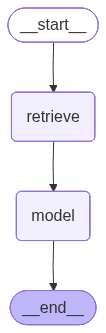

In [9]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [10]:
input_message = HumanMessage(content="Summarize the PDF")
ctx = ContextSchema(model_provider="openai", retriever=retriever)
result = graph.invoke({"messages": [input_message]}, context=ctx)
print(result["messages"][-1].content)

The PDF discusses advancements in training and fine-tuning language models for tasks such as summarization, generation, and arithmetic, emphasizing improvements in acceptance rates of model outputs.

Key points include:

- **Pythia-31M/1.4B on CNN/Daily Mail (Optimal-Epoch Training):** This involves fine-tuning models specifically for extractive summarization of long-form content like news articles. The "Optimal-Epoch" approach aims to maximize summarization performance through extended, task-specific training.

- **Task-Level Acceptance Rate Analysis:** A comparative study between two methods, AdaSPEC and DistillSpec, reveals that AdaSPEC consistently achieves higher acceptance rates for generated drafts across tasks. Histograms show a pronounced increase (rightward shift) in acceptance rates under AdaSPEC, indicating more frequent successful outputs.

- **Applications and Implications:** The improved acceptance rates reflect better practical utility of these language models in real-w